# Credit Scorecard Model Notebook
- Author: Marcellinus Aditya Witarsah
- Date: 27 May 2024

In [1]:
# Imports
%load_ext autoreload
%autoreload 2
%matplotlib inline
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import logging
import time
import pickle
from pathlib import Path
from abc import ABC
from abc import abstractmethod
from scipy import stats
from typing import Tuple
from typing import Union
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.calibration import calibration_curve
from sklearn.linear_model import LogisticRegression
from optbinning import Scorecard
from optbinning import BinningProcess
from optbinning.scorecard import Counterfactual

(CVXPY) Jun 04 08:10:47 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.10.4067). Expected < 9.10.0. Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Jun 04 08:10:47 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.10.4067). Expected < 9.10.0. Please open a feature request on cvxpy to enable support for this version.')


# About the Data
Table information about the dataset from [Kaggle](https://www.kaggle.com/datasets/laotse/credit-risk-dataset).
|      **Feature Name**      |               **Description**               |
|:--------------------------:|:-------------------------------------------:|
| person_age                 | Age                                         |
| person_income              | Annual Income                               |
| person_home_ownership      | Home ownership                              |
| person_emp_length          | Employment length (in years)                |
| loan_intent                | Loan intent                                 |
| loan_grade                 | Loan grade                                  |
| loan_amnt                  | Loan amount                                 |
| loan_int_rate              | Interest rate                               |
| loan_status                | Loan status (0 is non default 1 is default) |
| loan_percent_income        | Percent income                              |
| cb_person_default_on_file  | Historical default                          |
| cb_preson_cred_hist_length | Credit history length                       |

# Constants

In [34]:
# Constants
FIGSIZE = (12, 7)

# Data Load

In [9]:
log_fmt = "%(asctime)s - %(name)s - %(levelname)s - %(message)s"
logging.basicConfig(level=logging.INFO, format=log_fmt)
logger = logging.getLogger(__name__)

class DataIngestionStrategy(ABC):
    @abstractmethod
    def ingest_data(self, paths: list):
        pass

class PandasDataIngestionStrategy(DataIngestionStrategy):
    def ingest_data(self, paths: list) -> pd.DataFrame:
        """
        Ingests data using Pandas.

        Args:
            paths (list): List of file paths to ingest data from.
        Returns:
            pd.DataFrame: Ingested data as Pandas DataFrame.
        """
        df = pd.DataFrame({})
        for path in paths:
            path = Path(path)
            start = time.perf_counter()
            if path.suffix == ".csv":
                temp_df = pd.read_csv(path)
            elif path.suffix == ".parquet":
                temp_df = pd.read_parquet(path)
            df = pd.concat([df, temp_df], axis=0)
        return df

class PolarsDataIngestionStrategy(DataIngestionStrategy):
    def ingest_data(self, paths: list) -> pl.LazyFrame:
        """
        Ingests data using Polars.

        Args:
            paths (list): List of file paths to ingest data from.
        Returns:
            pl.LazyFrame: Ingested data as Polars LazyFrame.
        """
        df = None
        for path in paths:
            path = Path(path)
            start = time.perf_counter()
            if path.suffix == ".csv":
                temp_df = pl.scan_csv(path)
            elif path.suffix == ".parquet":
                temp_df = pl.scan_parquet(path)
            if df is None:
                df = temp_df
            else:
                df = pl.concat([df, temp_df], how="vertical")
        return df


class DataIngestion:
    @staticmethod
    def ingest_data(paths: str, strategy: DataIngestionStrategy) -> Union[pd.DataFrame, pl.LazyFrame]:
        """
        Ingests data using the specified strategy.

        Args:
            paths (list): List of file paths to ingest data from.
            strategy (DataIngestionStrategy): Strategy to use for data ingestion.
        Returns:
            Union[pd.DataFrame, pl.LazyFrame]: Ingested data as a DataFrame (for Pandas strategy) or LazyFrame (for Polars strategy).
        """
        df = None
        try:
            df = strategy.ingest_data(paths)
        except Exception as e:
            logger.error(e)
        return df

In [11]:
# Load and inspect data
df = DataIngestion.ingest_data(
    paths=[
        "../data/raw/credit_risk_dataset.csv"
    ],
    strategy=PandasDataIngestionStrategy()
)
display(df.head())
display(df.info())
display(df.describe())

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


None

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,32581.000000,3.258100e+04,31686.000000,32581.000000,29465.000000,32581.000000,32581.000000,32581.000000
mean,27.734600,6.607485e+04,4.789686,9589.371106,11.011695,0.218164,0.170203,5.804211
std,6.348078,6.198312e+04,4.142630,6322.086646,3.240459,0.413006,0.106782,4.055001
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000
25%,23.000000,3.850000e+04,2.000000,5000.000000,7.900000,0.000000,0.090000,3.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.990000,0.000000,0.150000,4.000000
75%,30.000000,7.920000e+04,7.000000,12200.000000,13.470000,0.000000,0.230000,8.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,1.000000,0.830000,30.000000


# Data Preparation
1. Data Splitting: Split the data into training and testing datasets.
2. Data Cleaning: Optionally handle missing values and anomalies in the training data, then apply the same transformations to the testing dataset. Note: WoE calculation already addresses these issues.
3. Weight of Evidence (WOE) and Information Value (IV) Calculation: Calculate the WoE and IV for each predictor variable.
4. Feature Selection: Select features based on their IV scores.
5. WoE Transformation: Transform the dataset values into WoE values using the calculated WoE mappings.

## Data Splitting

In [18]:
# Imports
%load_ext autoreload
%autoreload 2
from sklearn.model_selection import train_test_split

log_fmt = "%(asctime)s - %(name)s - %(levelname)s - %(message)s"
logging.basicConfig(level=logging.INFO, format=log_fmt)
logger = logging.getLogger(__name__)


class DataPreprocessing:
    @staticmethod
    def split_data(df: pd.DataFrame, target_variable: str, test_size: float, random_state: int) -> Tuple[pd.DataFrame, pd.Series, pd.DataFrame, pd.Series]:
        """
        Split data into train and test data evenly based on their target_variable values.

        Args:
            df (pd.DataFrame): Pandas DataFrame containing the data.
            target_variable (str): target_variable column.
            test_size (float): Proportion of dataset pick testing.
            random_state (int): Random state for splitting data.
        Returns:
            Tuple[pd.DataFrame, pd.Series, pd.DataFrame, pd.Series]: Train and test set.
        """
        X_train, X_test, y_train, y_test = (None, None, None, None,)
        try:
            X, y = df.drop(columns=[target_variable]), df[target_variable]
            X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=test_size, shuffle=True, random_state=random_state)
        except Exception as e:
            logger.error(e)
        return (X_train, X_test, y_train, y_test)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
# Prepare arguments
df = DataIngestion.ingest_data(
    paths=[
        "../data/raw/credit_risk_dataset.csv"
    ],
    strategy=PandasDataIngestionStrategy()
)
target_variable = 'loan_status'
test_size = 0.3
random_state = 42

# Split data betweem train and text
X_train, X_test, y_train, y_test = DataPreprocessing.split_data(
    df=df, 
    target_variable=target_variable,
    test_size=test_size,
    random_state=random_state
)

print(f'Train features: {X_train.shape}, Train Target: {y_train.shape}')
print(f'Test features: {X_test.shape}, Test Target: {y_test.shape}')

Train features: (22806, 11), Train Target: (22806,)
Test features: (9775, 11), Test Target: (9775,)


## Weight of Evidence (WOE) and Information Value (IV)
1. ***Weight of Evidence*** (WoE) measures how good each grouped attributes (inside a predictor variable) in predicting the desired value of the binary response variable (binary classification). The formula for calculating WoE is 
    $$ \text{WoE} = \ln \left( \frac{\text{Proportion of Good}}{\text{Proportion of Bad}} \right) $$
    Where:
    - $ \text{Proportion of Good} $ is the proportion of customers who paid back (**Good Customers**).
    - $ \text{Proportion of Bad}\ $ is the proportion of default customers (**Bad Customers**).
    - $ \text{ln} $ denotes the natural logarithm.

    How to interpret WoE? High positive value of WoE leads to a high proportion of Good Customers while the lower the value of WoE leads to a high proportion of Bad Customers.

2. ***Information Value*** (IV) is to measure the predictive power of the feature on the value of the specified binary response variable (0 or 1). The formula for calculating the IV is
    $$ \text{WoE} = \sum (\text{Proportion of Good} - \text{Proportion of Bad}) * \text{WoE} $$
    Here is the table shows the interpretation of each IV.
    | Information Value | Predictive Power                        |
    |-------------------|-----------------------------------------|
    | < 0.02            | Useless in modelling                    |
    | 0.02 - 0.1        | Weak predictor                          |
    | 0.1 - 0.3         | Medium predictor                        |
    | 0.3 - 0.5         | Strong predictor                        |
    | > 0.5             | Suspiciously good. Check further        |
    
    How to interpret IV? High value of IV leads to high predictive power of a feature. IV can also be used for feature selection which works by leaving out features with low IV. 


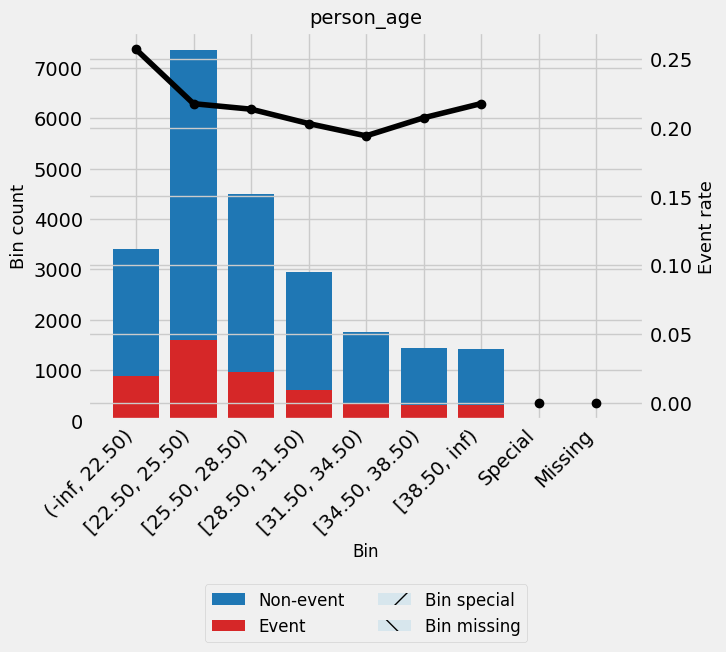

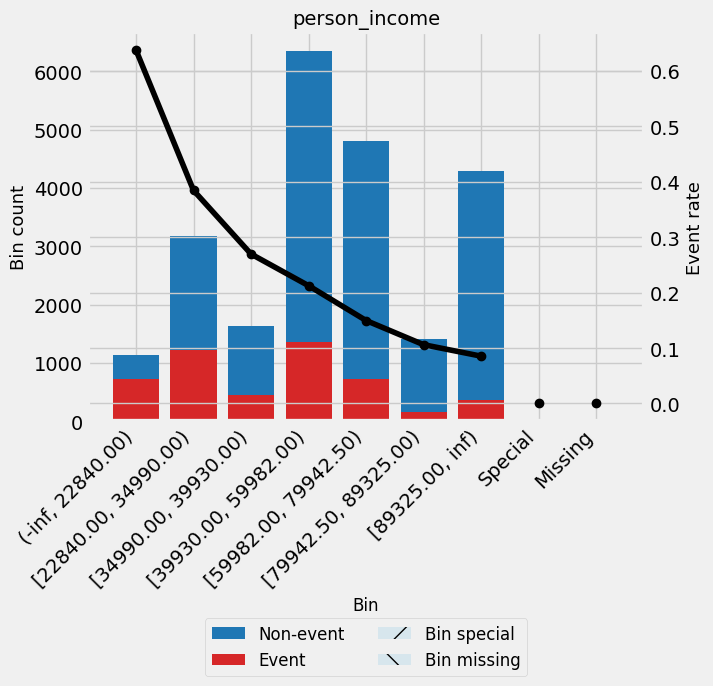

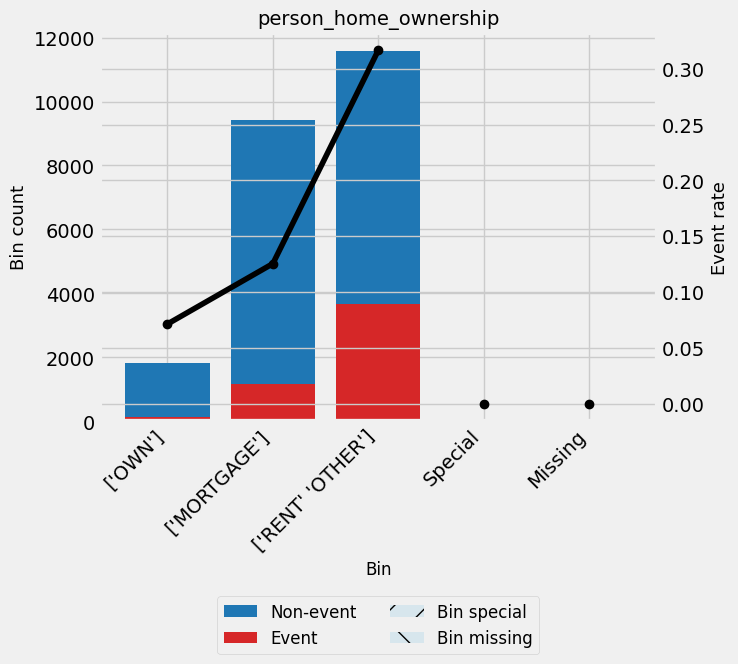

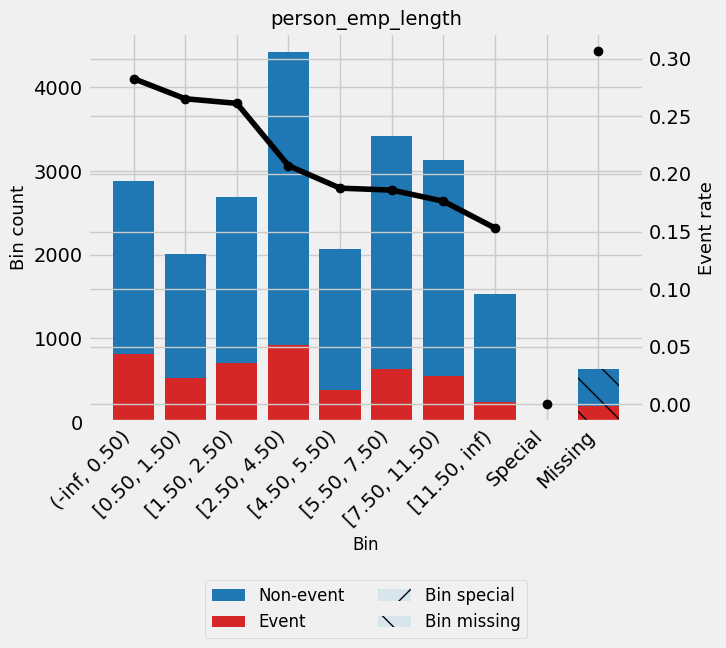

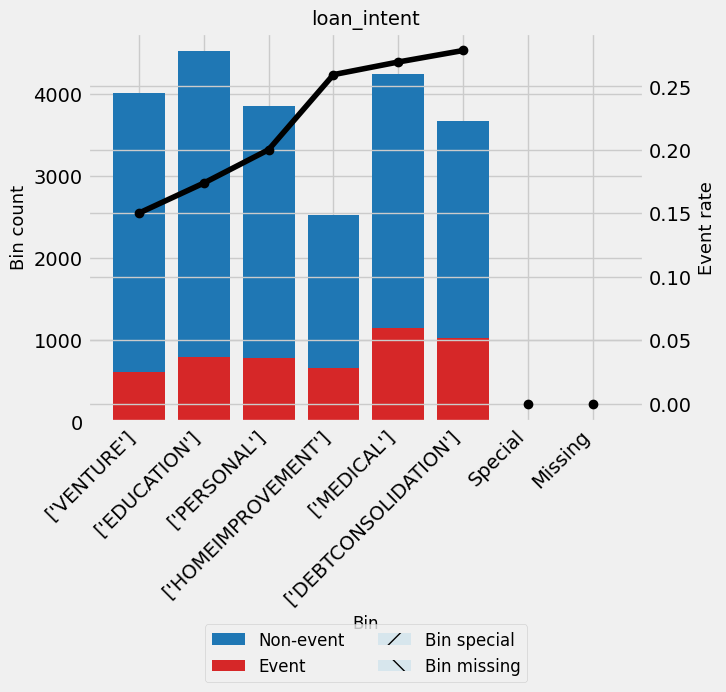

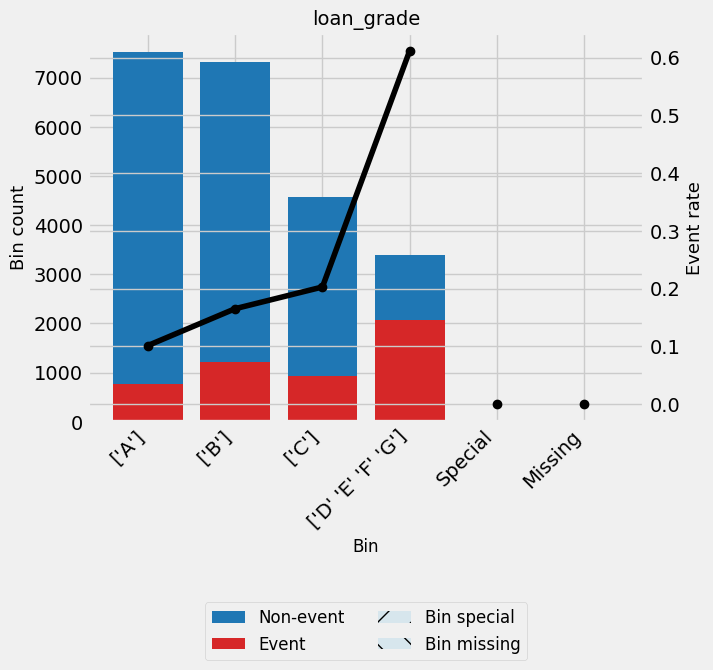

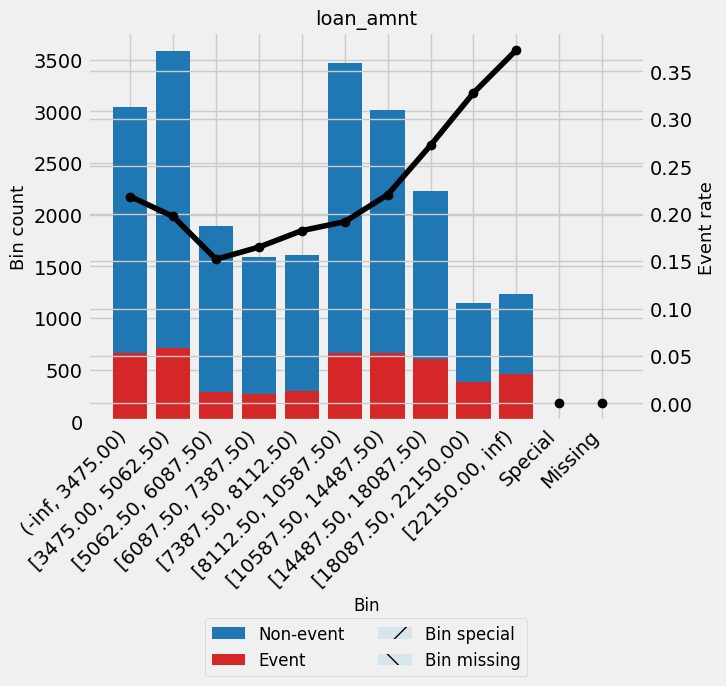

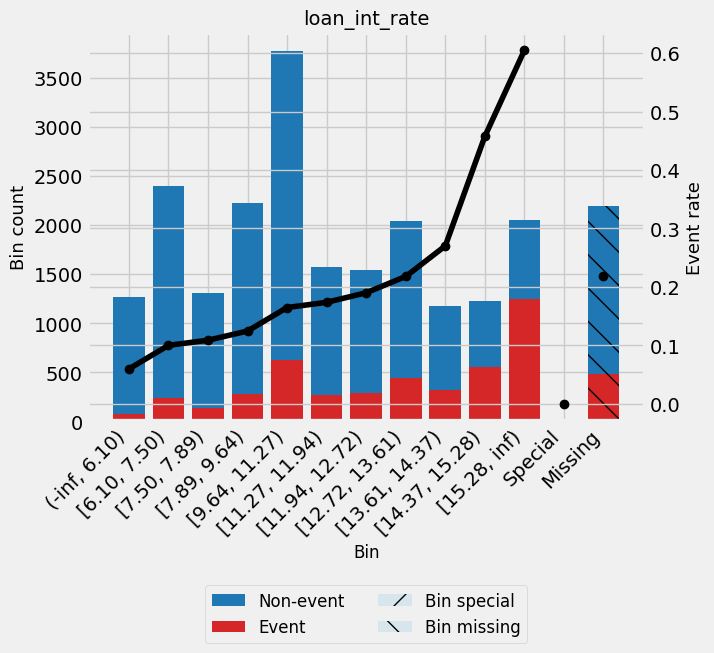

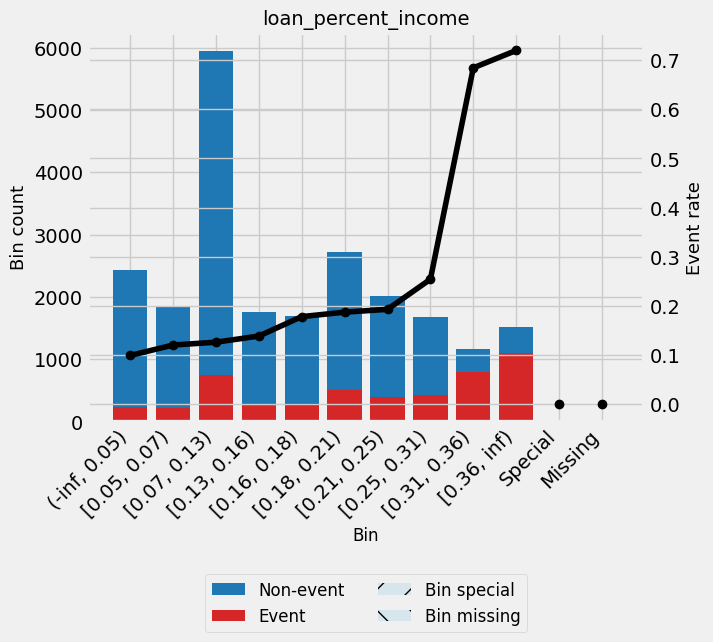

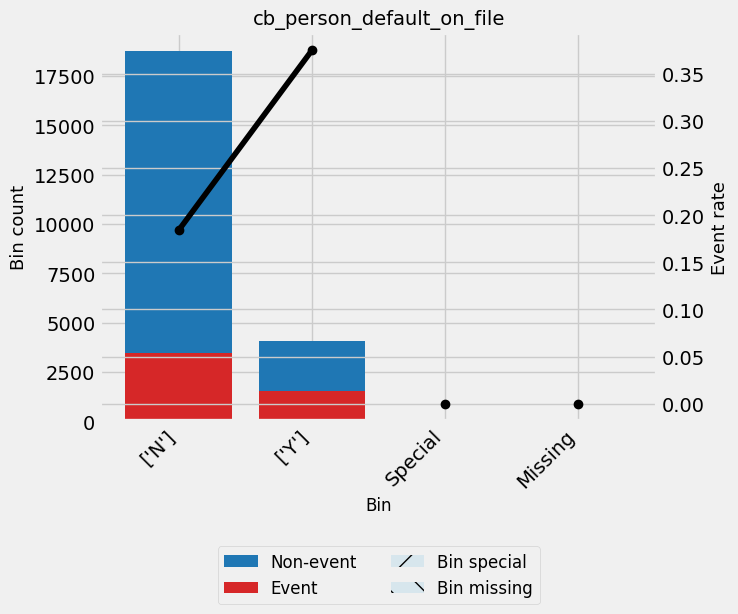

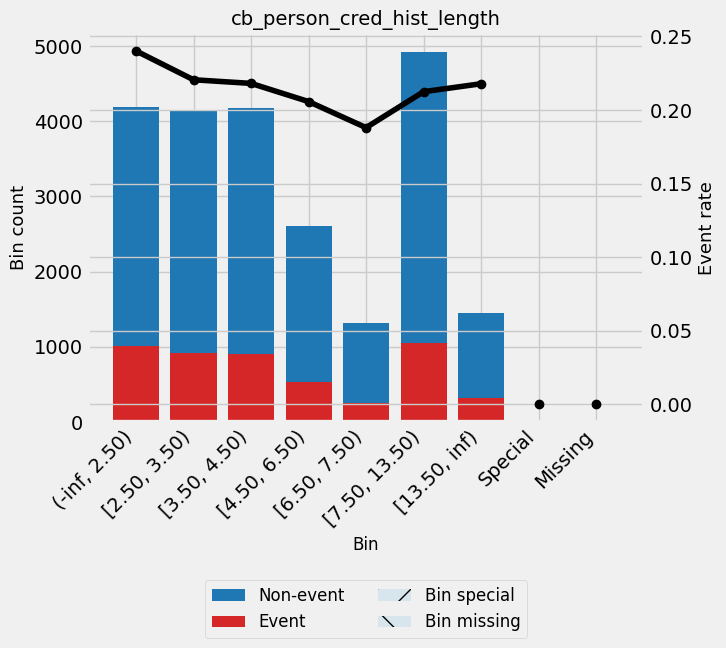

In [ ]:
# Perform binning and all explanatory variables
binning_process = BinningProcess(
    X_train.columns.values, 
    categorical_variables=X_train.select_dtypes("object").columns.tolist()
)

# Perform binning
binning_process.fit(X_train, y_train)

# Plot event_rate 
variables = binning_process.get_support(names=True)
for variable in variables:
    binning_table = binning_process.get_binned_variable(variable).binning_table
    binning_table.build()
    binning_table.plot(metric="event_rate", show_bin_labels=True)

1. Those who are still producing low income has a high probability of default.
2. Those who are still new in the job has a high probability of default.
3. High interest rate (`loan_int_rate`) has a high probability of default.
4. Hihg proportion of loan with respect to income (`loan_percent_income`) has a high probability of default. 

### Calculate WoE and IV
WOE and IV is already automatically calculated using the build() method

In [ ]:
characteristics = []
ivs = []
# Plot `woe`
variables = binning_process.get_support(names=True)
for variable in variables:
    binning_table = binning_process.get_binned_variable(variable).binning_table
    characteristics.append(variable)
    ivs.append(binning_table.build().loc["Totals", "IV"])

IV_df = pd.DataFrame({
    "Characteristic": characteristics,
    "IV": ivs
})

In [ ]:
def interpret_iv(score: float) -> str:
    """
    Interpret Information Score

    Args:
        score (float): Information Value.
    Returns:
        str: Interpretation of the score.
    """
    if score < 0.02:
        return "Not Predictive"
    elif 0.02 <= score and score < 0.1:
        return "Weak Predictive"
    elif 0.1 <= score and score < 0.3:
        return "Medium Predictive"
    elif 0.3 <= score and score < 0.5:
        return "Strong Predictive"
    else:
        return "Very Strong Predictive"

IV_df["Interpretation"] = IV_df["IV"].apply(lambda x: interpret_iv(x))
IV_df = IV_df.sort_values(by="IV", ascending=False)
IV_df

,Characteristic,IV,Interpretation
8,loan_percent_income,0.953721,Very Strong Predictive
5,loan_grade,0.834618,Very Strong Predictive
7,loan_int_rate,0.670894,Very Strong Predictive
1,person_income,0.576370,Very Strong Predictive
2,person_home_ownership,0.386377,Strong Predictive
9,cb_person_default_on_file,0.159914,Medium Predictive
6,loan_amnt,0.095098,Weak Predictive
4,loan_intent,0.088282,Weak Predictive
3,person_emp_length,0.066238,Weak Predictive
0,person_age,0.010358,Not Predictive


Exclude Characteristic with is interpret as `Not Predictive`

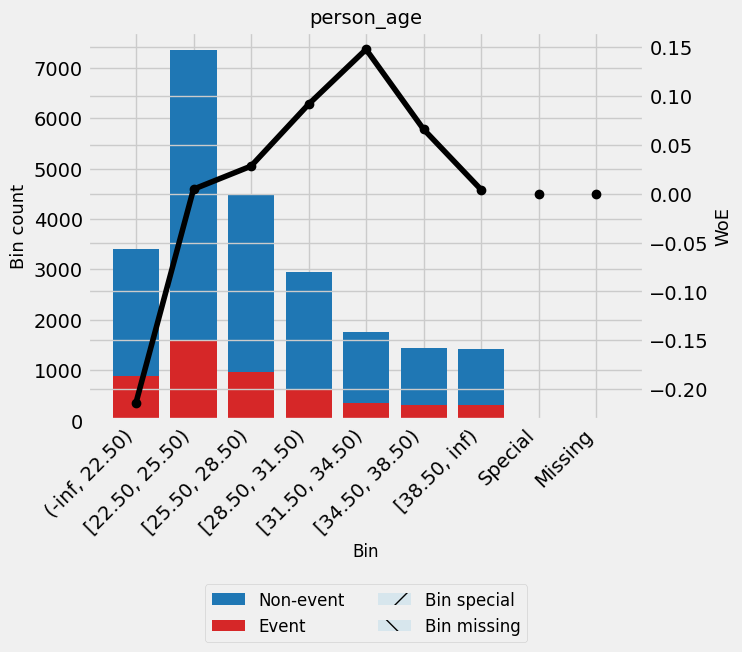

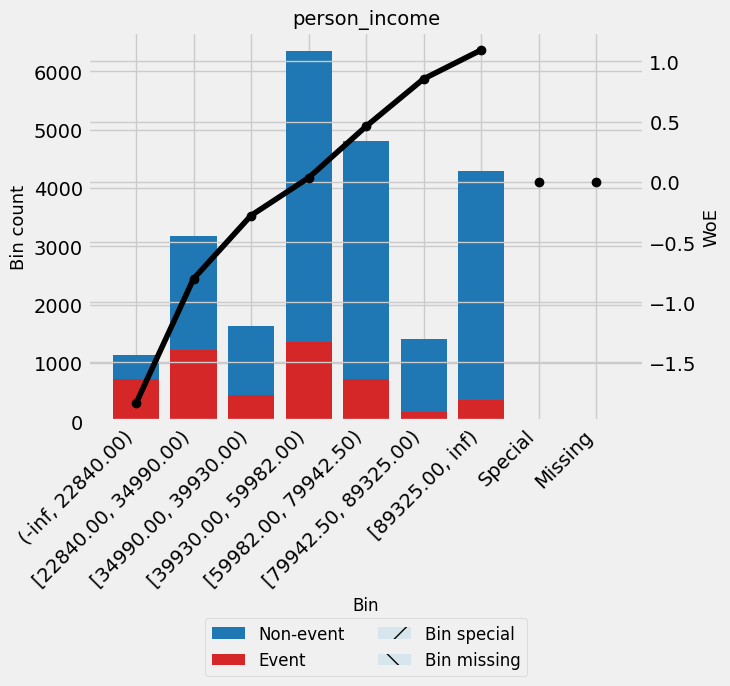

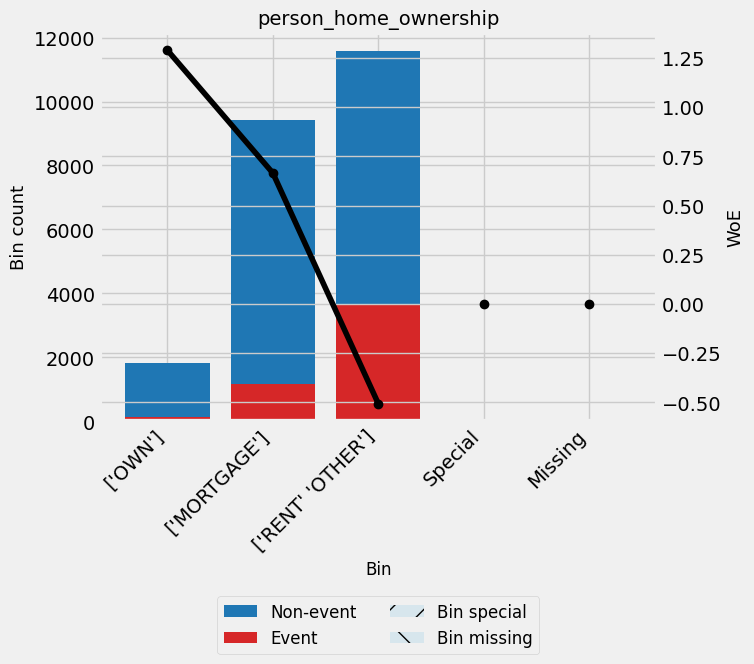

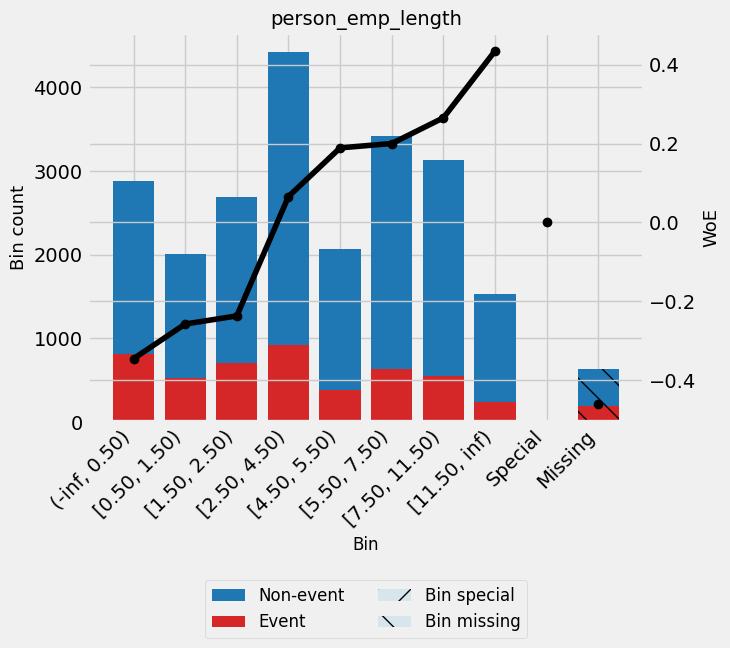

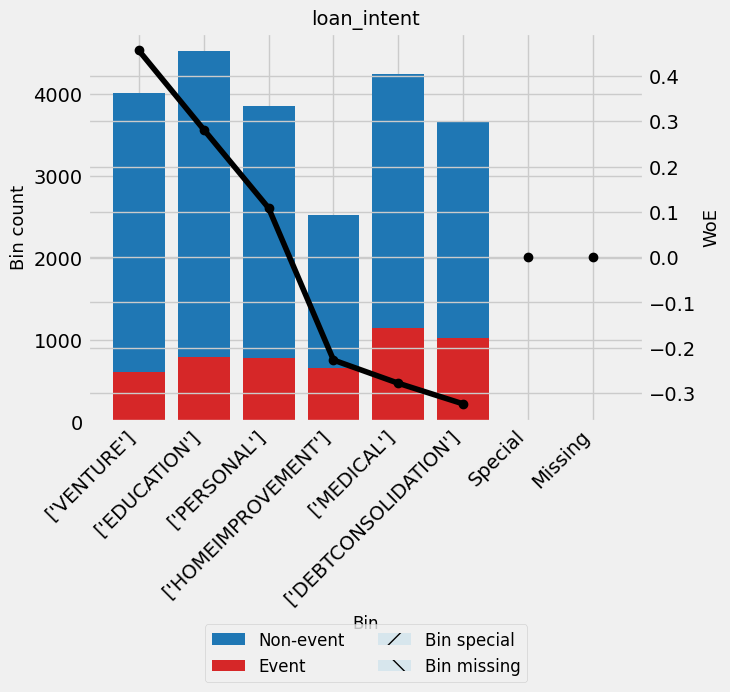

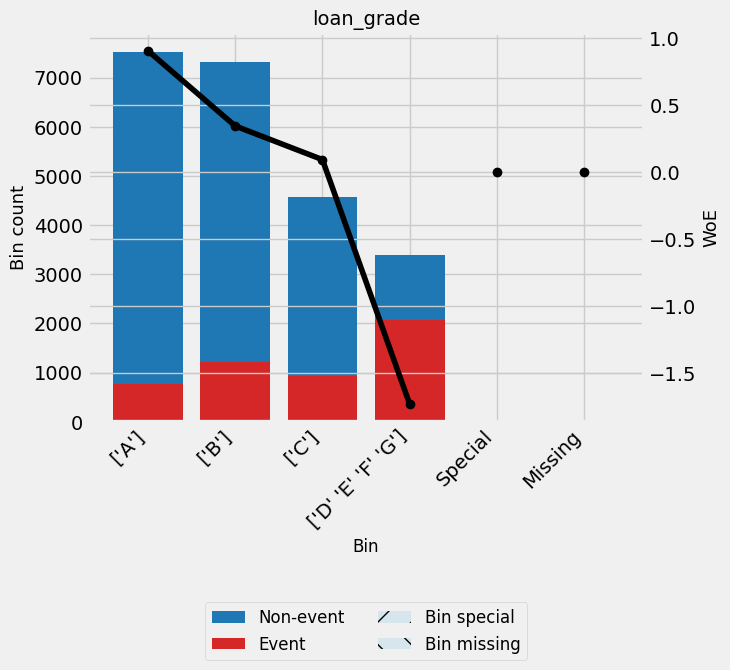

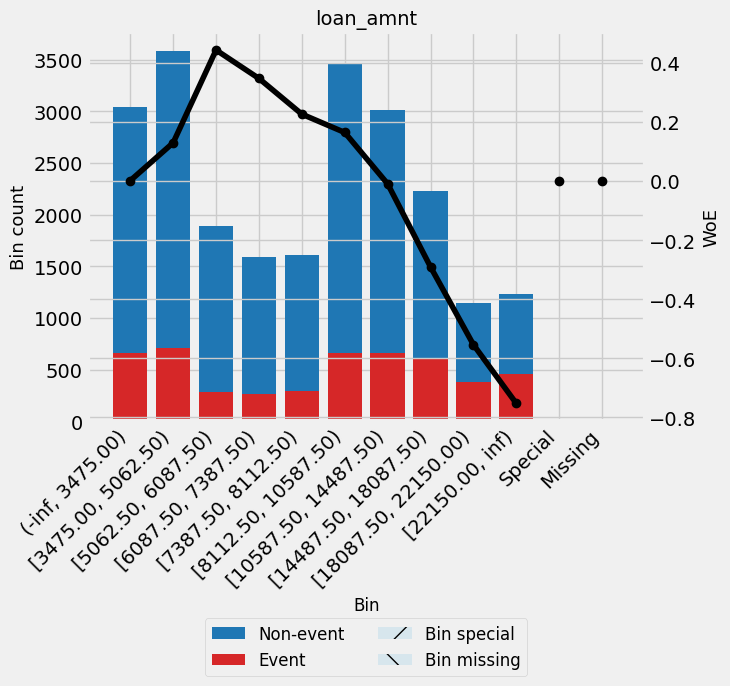

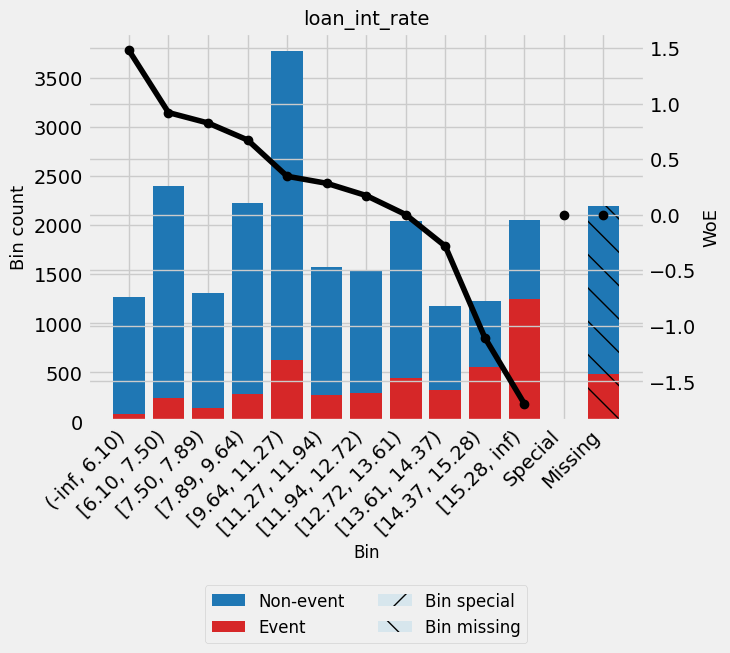

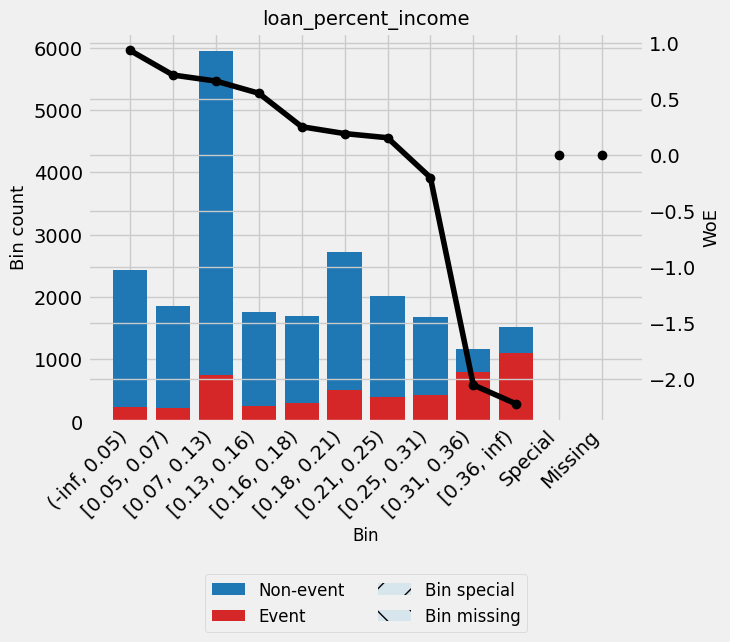

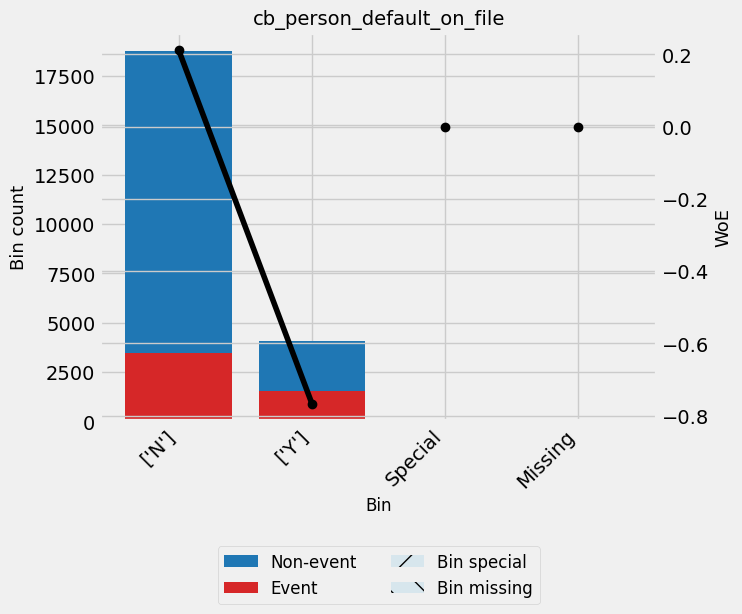

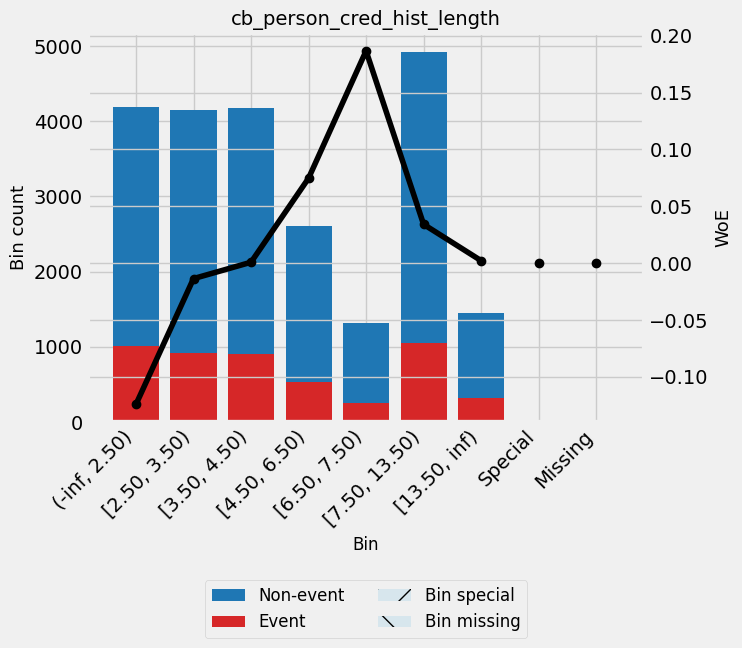

In [ ]:
# Plot `woe`
variables = binning_process.get_support(names=True)
for variable in variables:
    binning_table = binning_process.get_binned_variable(variable).binning_table
    binning_table.build()
    binning_table.plot(metric="woe", show_bin_labels=True)
    # binning_table.plot(metric="woe", show_bin_labels=True, savefig=f"../reports/figures/woe_plot_{variable}.png", figsize=FIGSIZE)

# Modelling
Use Logistic Regression due to its simplicity, interpretability, and transparency in prediction.

In [45]:
class ModelTraining:
    def __init__(self, config: ModelTrainingConfig):
        """
        Instantiate `ModelTraining` class

        Args:
            config (ModelTrainingConfig): Configuration for model training
        """
        self.config = config

    def train(self):
        """
        Train and save model
        """
        # Data ingestion
        df = DataIngestion.ingest_data(
            paths=[
                data_path
            ],
            strategy=PandasDataIngestionStrategy()
        )

        # Data Preprocessing
        X_train, X_test, y_train, y_test = DataPreprocessing.split_data(
            df=df, 
            target_variable=target_variable,
            test_size=test_size,
            random_state=random_state
        )

        # Instantiate BinningProcess and Logistic Regression
        binning_process = BinningProcess(
            X_train.columns.values, 
            categorical_variables=categorical_variables, 
            selection_criteria={
                'iv': {
                    'min': feature_selection_min_iv,
                    'max': feature_selection_max_iv
                }
            },
        )
        logreg_model = LogisticRegression(random_state=random_state) 

        # Instantiate Scorecard Model
        scorecard = Scorecard(
            binning_process=binning_process,
            estimator=logreg_model,
            scaling_method=scorecard_scaling_method,
            scaling_method_params={
                'pdo': scorecard_scaling_method_pdo,
                'odds': scorecard_scaling_method_odds,
                'scorecard_points': scorecard_scaling_method_scorecard_points
            },  # FICO score range
            intercept_based=scorecard_intercept_based
        )
        logger.info("Save model")
        scorecard.save("../models/woe_lr_scorecard.pkl")

class ModelInference:
    pass

NameError: name 'ModelTrainingConfig' is not defined

In [43]:
# Prepare arguments
data_path = '../data/raw/credit_risk_dataset.csv'
target_variable = 'loan_status'
test_size = 0.3
random_state = 42
feature_selection_min_iv = 0.02
feature_selection_max_iv = 1
scorecard_scaling_method ='pdo_odds'
scorecard_scaling_method_pdo = 20
scorecard_scaling_method_odds = 1
scorecard_scaling_method_scorecard_points = 500
scorecard_intercept_based = True
categorical_variables = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']

# Data ingestion
df = DataIngestion.ingest_data(
    paths=[
        data_path
    ],
    strategy=PandasDataIngestionStrategy()
)

# Data Preprocessing
X_train, X_test, y_train, y_test = DataPreprocessing.split_data(
    df=df, 
    target_variable=target_variable,
    test_size=test_size,
    random_state=random_state
)

# Instantiate BinningProcess and Logistic Regression
binning_process = BinningProcess(
    X_train.columns.values, 
    categorical_variables=categorical_variables, 
    selection_criteria={
        'iv': {
            'min': feature_selection_min_iv,
            'max': feature_selection_max_iv
        }
    },
)
logreg_model = LogisticRegression(random_state=random_state) 


# Instantiate Scorecard Model
scorecard = Scorecard(
    binning_process=binning_process,
    estimator=logreg_model,
    scaling_method=scorecard_scaling_method,
    scaling_method_params={
        'pdo': scorecard_scaling_method_pdo,
        'odds': scorecard_scaling_method_odds,
        'scorecard_points': scorecard_scaling_method_scorecard_points
    },  # FICO score range
    intercept_based=scorecard_intercept_based
)

# Train
scorecard.fit(X_train, y_train)

Scorecard(binning_process=BinningProcess(categorical_variables=['person_home_ownership',
                                                                'loan_intent',
                                                                'loan_grade',
                                                                'cb_person_default_on_file'],
                                         selection_criteria={'iv': {'max': 1,
                                                                    'min': 0.02}},
                                         variable_names=array(['person_age', 'person_income', 'person_home_ownership',
       'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt',
       'loan_int_rate', 'loan_percent_income',
       'cb_person_default_on_file', 'cb_person_cred_hist_length'],
      dtype=object)),
          estimator=LogisticRegression(random_state=42), intercept_based=True,
          scaling_method='pdo_odds',
          scaling_method_params={'odds': 1, 'pdo': 20, 'scorecard_points': 500})

# Evaluation

In [38]:
import numpy as np
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve

class Evaluation:
    @staticmethod
    def roc_auc(y_true: Union[list, np.array], y_pred_proba: Union[list, np.array]) -> float:
        """
        Calculate ROC AUC (Area Under the Receiver Operating Characteristic Curve).
        
        Args:
            y_true (Union[list, np.array]): True labels.
            y_pred_prob (Union[list, np.array]): Prediction probability of target class of `1`
        Returns:
            float: ROC AUC score.
        """
        return roc_auc_score(y_true, y_pred_proba)

    @staticmethod
    def pr_auc(y_true: Union[list, np.array], y_pred_proba: Union[list, np.array]) -> float:
        """
        Calculate PR AUC (Area Under the Precision Recall Curve).
        
        Args:
            y_true (Union[list, np.array]): True labels.
            y_pred_prob (Union[list, np.array]): Prediction probability of target class of `1`
        Returns:
            float: PR AUC score.
        """
        precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
        return auc(recall, precision)

    @staticmethod
    def gini(y_true: Union[list, np.array], y_pred_proba: Union[list, np.array]) -> float:
        """
        Calculate Gini coefficient.

        Args:
            y_true (Union[list, np.array]): True labels.
            y_pred_prob (Union[list, np.array]): Prediction probability of target class of `1`
        Returns:
            float: Gini coefficient.
        """
        roc_auc = roc_auc_score(y_true, y_pred_proba)
        return 2 * roc_auc - 1

    @staticmethod
    def ks(y_true: Union[list, np.array], y_pred_proba: Union[list, np.array]) -> float:
        """
        Calculate Kolmogorov-Smirnov (KS) statistic.

        Args:
            y_true (Union[list, np.array]): True labels.
            y_pred_prob (Union[list, np.array]): Prediction probability of target class of `1`
        Returns:
            float: KS statistic.
        """
        y_pred_proba_not_default = y_pred_proba[y_true == 0]
        y_pred_proba_default = y_pred_proba[y_true == 1]
        ks_stat, p_value = stats.ks_2samp(y_pred_proba_not_default, y_pred_proba_default)
        return ks_stat

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.calibration import calibration_curve
from scipy import stats

def plot_pred_proba_distribution(y_true: np.array, y_pred_proba: np.array, figsize: Tuple[int, int]) -> plt.Axes:
    """
    Plot the predicted probability distributions for the default and non-default classes.
    
    Args:
        y_pred_proba (np.array): Predicted probabilities for the positive class (default).
        y_true (np.array): True binary labels (0 for not default, 1 for default).
        figsize (Tuple[int, int]): size of the plot.
    Return:
        plt.Axes: Matplotlib axis object.
    """
    plt.style.use('fivethirtyeight')
    fig, ax = plt.subplots(figsize=figsize)

    sns.histplot(y_pred_proba[y_true == 0], label="Not Default", kde=True, color='blue', alpha=0.6, bins=30, ax=ax)
    sns.histplot(y_pred_proba[y_true == 1], label="Default", kde=True, color='red', alpha=0.6, bins=30, ax=ax)

    ax.set_title('Predicted Probability Distributions for Default and Not Default', fontsize=16, fontweight='bold')
    ax.set_xlabel('Predicted Probability', fontsize=14)
    ax.set_ylabel('Frequency', fontsize=14)
    ax.legend(title='Label', fontsize=12, title_fontsize='13')
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    return ax

def plot_roc_auc_curve(y_true: np.array, y_pred_proba: np.array, figsize: Tuple[int, int]) -> plt.Axes:
    """
    Plot the ROC curve and calculate the AUC.
    
    Args:
        y_pred_proba (np.array): Predicted probabilities for the positive class (default).
        y_true (np.array): True binary labels (0 for not default, 1 for default).
        figsize (Tuple[int, int]): size of the plot.
    Return:
        plt.Axes: Matplotlib axis object.
    """
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.style.use('fivethirtyeight')
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(fpr, tpr, lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    ax.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')

    ax.set_title('Receiver Operating Characteristic (ROC) Curve', fontsize=16, fontweight='bold')
    ax.set_xlabel('False Positive Rate', fontsize=14)
    ax.set_ylabel('True Positive Rate', fontsize=14)
    ax.legend(loc="lower right", fontsize=12)
    ax.grid(axis='both', linestyle='--', alpha=0.7)

    return ax

def plot_precision_recall_curve(y_true: np.array, y_pred_proba: np.array, figsize: Tuple[int, int]) -> plt.Axes:
    """
    Plot the Precision-Recall curve and calculate the Average Precision (AP).
    
    Args:
        y_pred_proba (np.array): Predicted probabilities for the positive class (default).
        y_true (np.array): True binary labels (0 for not default, 1 for default).
        figsize (Tuple[int, int]): size of the plot.
    Return:
        plt.Axes: Matplotlib axis object.
    """
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred_proba)
    pr_auc = auc(recall, precision)

    plt.style.use('fivethirtyeight')
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(recall, precision, lw=2, label=f'PR curve (AP = {pr_auc:.2f})')

    ax.set_title('Precision-Recall Curve', fontsize=16, fontweight='bold')
    ax.set_xlabel('Recall', fontsize=14)
    ax.set_ylabel('Precision', fontsize=14)
    ax.legend(loc="lower left", fontsize=12)
    ax.grid(axis='both', linestyle='--', alpha=0.7)

    return ax

def plot_ks(y_true: np.array, y_pred_proba: np.array, figsize: Tuple[int, int]) -> plt.Axes:
    """
    Plot the Kolmogorov-Smirnov (KS) statistic.
    
    Args:
        y_pred_proba (np.array): Predicted probabilities for the positive class (default).
        y_true (np.array): True binary labels (0 for not default, 1 for default).
        figsize (Tuple[int, int]): size of the plot.
    Return:
        plt.Axes: Matplotlib axis object.
    """
    y_pred_proba_not_default = y_pred_proba[y_true == 0]
    y_pred_proba_default = y_pred_proba[y_true == 1]

    ks_stat, p_value = stats.ks_2samp(y_pred_proba_not_default, y_pred_proba_default)

    plt.style.use('fivethirtyeight')
    fig, ax = plt.subplots(figsize=figsize)
    ax.hist(y_pred_proba_not_default, bins=50, density=True, histtype='step', cumulative=True, label='Not Default', linewidth=2)
    ax.hist(y_pred_proba_default, bins=50, density=True, histtype='step', cumulative=True, label='Default', linewidth=2)
    ax.set_title('KS Plot')
    ax.set_xlabel('Value')
    ax.set_ylabel('Cumulative Probability')
    ax.legend(title=f'KS Statistic: {ks_stat:.3f}, P-value: {p_value:.3f}')

    return ax

def plot_calibration_curve(y_true: np.array, y_pred_proba: np.array, model_name: str, figsize: Tuple[int, int], n_bins=10) -> plt.Axes:
    """
    Plot calibration curve.

    Args:
        y_pred_proba (np.array): Predicted probabilities for the positive class (default).
        y_true (np.array): True binary labels (0 for not default, 1 for default).
        model_name (str): Name of the model for labeling the plot.
        figsize (Tuple[int, int]): size of the plot.
        n_bins (int): Number of bins to use for calibration curve.
    Return:
        plt.Axes: Matplotlib axis object.
    """
    prob_true, prob_pred = calibration_curve(y_true, y_pred_proba, n_bins=n_bins)
    
    plt.style.use('fivethirtyeight')
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
    ax.plot(prob_pred, prob_true, marker='o', label=model_name)
    
    ax.set_xlabel('Mean predicted probability')
    ax.set_ylabel('Fraction of positives')
    ax.set_title('Calibration plot')
    ax.legend()
    ax.grid(True)

    return ax

In [40]:
def print_side_by_side(dict1: dict, dict2: dict) -> None:
    """
    Prints the content of two dictionaries side by side.

    Args:
        dict1 (dict): The first dictionary to be printed.
        dict2 (dict): The second dictionary to be printed.

    Returns:
        None
    """
    # Calculate the maximum length of keys in both dictionaries
    max_key_len = max(max(len(key) for key in dict1), max(len(key) for key in dict2))
    
    # Define the format string for printing
    format_str = "{:<{key_len}}: {:<8} | {:<8}"
    
    # Print header
    print(format_str.format("Metric", "Train", "Test", key_len=max_key_len))
    
    # Print separator
    print("-" * (max_key_len + 21))
    
    # Print key-value pairs side by side
    for key in dict1:
        print(format_str.format(key, dict1[key], dict2[key], key_len=max_key_len))


## Explanation
- From the evaluation results it seems there's no indication of overfitting which is good because the model performances are similar between training and testing set
- **The most important thins is the model calibration which is close to the perfect calibrated model**. Why is it so important? it ensures all business decision makers that the model estimated probabilities aligns with the actual default rate in the population of actual borrowers. For example, if the model is perfectly calibrated and the model predict that chance of someone default is 10% and the bank trust it. For every loan given to all borrowers with predicted probabilit of default 10%, then they expect on average that 10% of all borrowers will default.
- It is impossible that the model follow the perfectly callibrated line. If it does, it could be possible indication of an overfitting. 
- If the **point lies below the perfectly calibrated line** it means that **the model underpredicting the probability of "Bad" users**. Conversely, if a **point lies above the perfectly calibrated line** it means that **the model overpredicting the probability of the a "Bad" users**.

## Save Model

In [ ]:
# Save model
scorecard.save("../models/woe_lr_scorecard.pkl")

# Model Explanation

In [ ]:
intercept = scorecard.estimator_.intercept_
variables = scorecard.binning_process_.get_support(names=True)
coefs = scorecard.estimator_.coef_.reshape(-1)

print("Intercept(s): ", intercept)
print("Coef:")
for feature, coef in zip(variables, coefs):
    print(f"{feature} = {coef:.5f}")

Intercept(s):  [-1.37705614]
Coef:
person_income = -0.87756
person_home_ownership = -0.92643
person_emp_length = -0.33133
loan_intent = -1.47550
loan_grade = -1.17381
loan_amnt = -0.55066
loan_int_rate = -0.10071
loan_percent_income = -0.98299
cb_person_default_on_file = 0.03970


## Explanation
Explanation of parameters inside the Logistic Regression:
1. Intercept (`intercept_`): It's the average chance of default when all other predictor variables are zero.
2. Coefficients (`coef_`): These numbers show how much each factor affects the chance of default:
    - Negative numbers mean the factor lowers the chance of default. For example, if weight of evidence person_income goes up, the chance of default goes down.
    - Positive numbers mean the factor increases the chance of default. For instance, if weight of evidence cb_person_default_on_file is 'Yes', it increases the chance of default.

Based on these coefficients if the Weight of Evidence is positively big (high percentage of non default customers) the lower the change of default because it is multiploed by the negative coefficient. Otherwise if the Weight of Evidence is massively negative (high percentage of non customers) the higher the chance of default because massive negatice values multiplied by negative coefficients result in positive log of the odds which increase the probability of default in the final prediction.

# Scaling and Creating Scorecard
Credit scorecard will show how the Points represented by the bins generated from the predictor variable. Generating the score points will involve scaling calculations from the logistic regression parameters and WoE(s) from grouped attributes inside each characteristics. In general the relationship between the scores and odds can be presented and linear equation:
$$ \text{Score} = Offset + (Factor * \ln{(Odds)}) $$

The scorecard is being developed using a **specified odds** and **points to double the odds** (*pdo*). The $ Offset $ and $ Factor $ can be calculated by using these formula:
$$ \text{Score} = Offset + (Factor * \ln{(Odds)}) $$
$$ \text{Score} + \text{pdo} = Offset + (Factor * \ln{(2 * Odds)}) $$

By solving the equation above for getting pdo, we get:
$$ \text{pdo} = Factor * \ln{(2)} \text{, therefore } Factor = \text{pdo} / \ln{(2)} $$
$$ \text{Offset} = Score - {Factor * \ln(Odds)}$$

After calculating, Factor and Offset we can start using the same formula for calculate the total score. The difference is we replace the $ \ln{(Odds)} $ with the linear equation from the logistic regression. 
$$ \text{Score} = Offset + Factor * \ln{(Odds)} = $$
$$ \text{Score} = - (\sum_{j,i=1}^{k,n}(WoE_{j}*\beta_{i})+a) * Factor + Offset  $$
$$ \text{Score} = - (\sum_{j,i=1}^{k,n}(WoE_{j}*\beta_{i}+\frac{a}{n})) * Factor + Offset  $$
$$ \text{Score} = \sum_{j,i=1}^{k,n}(-(WoE_{j}*\beta_{i}+\frac{a}{n}) * Factor + \frac{Offset}{n})  $$

We can modify the final equation to calculate the score for each grouped attribute inside each characteristic by removing the sum because we only wanted to calculate a single attribute score.
$$ \text{Attribute Score} = -(WoE_{j}*\beta_{i}+\frac{a}{n}) * Factor + \frac{Offset}{n}  $$

Where:
- $ WOE $ = weight of evidence for each grouped attribute
- $ \beta $ = regression coefficient for each characteristic
- $ a $ = intercept term from logistic regression
- $ n $ = number of characteristics
- $ k $ = number of groups (of attributes) in each characteristic

Source: https://www.amazon.com/Credit-Risk-Scorecards-Implementing-Intelligent/dp/047175451X

In [ ]:
# Load model
with open("../models/woe_lr_scorecard.pkl", "rb") as f:
    scorecard = pickle.load(f)
    display(scorecard)

# Show scorecard table
scorecard_table = scorecard.table(style="summary").reset_index(drop=True)
scorecard_table.to_csv("../reports/credit_scorecard.csv", index=False)

Scorecard(binning_process=BinningProcess(categorical_variables=['person_home_ownership',
                                                                'loan_intent',
                                                                'loan_grade',
                                                                'cb_person_default_on_file'],
                                         selection_criteria={'iv': {'max': 1,
                                                                    'min': 0.02}},
                                         variable_names=array(['person_age', 'person_income', 'person_home_ownership',
       'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt',
       'loan_int_rate', 'loan_percent_income',
       'cb_person_default_on_file', 'cb_person_cred_hist_length'],
      dtype=object)),
          estimator=LogisticRegression(random_state=42), intercept_based=True,
          scaling_method='pdo_odds',
          scaling_method_params={'odds': 1, 'pdo': 20, 'scorecard_points': 500})

## Point Allocation Checking
See if the allocation poitns to each bin make sense

In [ ]:
# Point allocation checking
for variable in scorecard_table['Variable'].unique():
    mask = scorecard_table['Variable'] == variable
    display(variable, scorecard_table[mask])

'person_income'

,Variable,Bin,Points
0,person_income,"(-inf, 22840.00)",0.000000
1,person_income,"[22840.00, 34990.00)",26.221545
2,person_income,"[34990.00, 39930.00)",39.533573
3,person_income,"[39930.00, 59982.00)",47.464580
4,person_income,"[59982.00, 79942.50)",58.286453
5,person_income,"[79942.50, 89325.00)",68.270059
6,person_income,"[89325.00, inf)",74.340219
7,person_income,Special,46.614775
8,person_income,Missing,46.614775


'person_home_ownership'

,Variable,Bin,Points
9,person_home_ownership,[OWN],48.024647
10,person_home_ownership,[MORTGAGE],31.338392
11,person_home_ownership,"[RENT, OTHER]",0.000000
12,person_home_ownership,Special,13.551648
13,person_home_ownership,Missing,13.551648


'person_emp_length'

,Variable,Bin,Points
14,person_emp_length,"(-inf, 0.50)",0.000000
15,person_emp_length,"[0.50, 1.50)",0.840747
16,person_emp_length,"[1.50, 2.50)",1.036944
17,person_emp_length,"[2.50, 4.50)",3.930335
18,person_emp_length,"[4.50, 5.50)",5.108914
19,person_emp_length,"[5.50, 7.50)",5.214435
20,person_emp_length,"[7.50, 11.50)",5.837325
21,person_emp_length,"[11.50, inf)",7.458419
22,person_emp_length,Special,3.301746
23,person_emp_length,Missing,3.301746


'loan_intent'

,Variable,Bin,Points
24,loan_intent,[VENTURE],33.211879
25,loan_intent,[EDUCATION],25.784245
26,loan_intent,[PERSONAL],18.407014
27,loan_intent,[HOMEIMPROVEMENT],4.120939
28,loan_intent,[MEDICAL],1.939734
29,loan_intent,[DEBTCONSOLIDATION],0.000000
30,loan_intent,Special,13.788376
31,loan_intent,Missing,13.788376


'loan_grade'

,Variable,Bin,Points
32,loan_grade,[A],89.294591
33,loan_grade,[B],70.278884
34,loan_grade,[C],61.776994
35,loan_grade,"[D, E, F, G]",0.000000
36,loan_grade,Special,58.657131
37,loan_grade,Missing,58.657131


'loan_amnt'

,Variable,Bin,Points
38,loan_amnt,"(-inf, 3475.00)",11.993233
39,loan_amnt,"[3475.00, 5062.50)",14.028526
40,loan_amnt,"[5062.50, 6087.50)",19.021064
41,loan_amnt,"[6087.50, 7387.50)",17.490786
42,loan_amnt,"[7387.50, 8112.50)",15.569868
43,loan_amnt,"[8112.50, 10587.50)",14.583778
44,loan_amnt,"[10587.50, 14487.50)",11.819597
45,loan_amnt,"[14487.50, 18087.50)",7.349553
46,loan_amnt,"[18087.50, 22150.00)",3.162700
47,loan_amnt,"[22150.00, inf)",0.000000


'loan_int_rate'

,Variable,Bin,Points
50,loan_int_rate,"(-inf, 6.10)",9.246613
51,loan_int_rate,"[6.10, 7.50)",7.619173
52,loan_int_rate,"[7.50, 7.89)",7.346527
53,loan_int_rate,"[7.89, 9.64)",6.902230
54,loan_int_rate,"[9.64, 11.27)",5.952468
55,loan_int_rate,"[11.27, 11.94)",5.769099
56,loan_int_rate,"[11.94, 12.72)",5.448459
57,loan_int_rate,"[12.72, 13.61)",4.949686
58,loan_int_rate,"[13.61, 14.37)",4.123449
59,loan_int_rate,"[14.37, 15.28)",1.730949


'loan_percent_income'

,Variable,Bin,Points
63,loan_percent_income,"(-inf, 0.05)",89.552854
64,loan_percent_income,"[0.05, 0.07)",83.325758
65,loan_percent_income,"[0.07, 0.13)",81.798799
66,loan_percent_income,"[0.13, 0.16)",78.710271
67,loan_percent_income,"[0.16, 0.18)",70.224877
68,loan_percent_income,"[0.18, 0.21)",68.495044
69,loan_percent_income,"[0.21, 0.25)",67.440092
70,loan_percent_income,"[0.25, 0.31)",57.359956
71,loan_percent_income,"[0.31, 0.36)",4.807273
72,loan_percent_income,"[0.36, inf)",0.000000


'cb_person_default_on_file'

,Variable,Bin,Points
75,cb_person_default_on_file,[N],0.000000
76,cb_person_default_on_file,[Y],1.120487
77,cb_person_default_on_file,Special,0.242127
78,cb_person_default_on_file,Missing,0.242127


`loan_amount` points doesn't show any increasing or decreasing value this might be due to the fact that the loan amount (big or small) doesn't matter as long as the applicant has high income. 

## Present Report to User/ Management

In [ ]:
credit_levels_decriptions = {
    1: "Very Poor",
    2: "Poor",
    3: "Below Average",
    4: "Average",
    5: "Above Average",
    6: "Good",
    7: "Very Good",
    8: "Excellent",
    9: "Exceptional",
}

def get_credit_levels(
    df: pd.DataFrame,
    target_col: str = "credit_score",
    left_bound = -np.inf,
    level_1 = 350,
    level_2 = 400,
    level_3 = 450,
    level_4 = 500,
    level_5 = 550,
    level_6 = 600,
    level_7 = 650,
    level_8 = 700,
    right_bound = np.inf
) -> pd.DataFrame:
    """
    Explain the credit levels and description for all FICO credit scores.

    Args:
        df (pd.DataFrame): The dataframe containing the credit score
        target_col (str): Column containing FICO credit score.
        left_bound (int): Lowest possible FICO credit score.
        level_1 (int): Value where the credit scores are equal or below will be categorize as level 1.
        level_2 (int): Value where the credit scores are equal or below will be categorize as level 2.
        level_3 (int): Value where the credit scores are equal or below will be categorize as level 3.
        level_4 (int): Value where the credit scores are equal or below will be categorize as level 4.
        right_bound (int): Lowest possible FICO credit score.

    Returns:
        float: The dataframe containing the credit levels and descriptions for all credit scores.
    """
    levels = []
    conditions = [
        (df[target_col] > left_bound) & (df[target_col] <= level_1),
        (df[target_col] > level_1) & (df[target_col] <= level_2),
        (df[target_col] > level_2) & (df[target_col] <= level_3),
        (df[target_col] > level_3) & (df[target_col] <= level_4),
        (df[target_col] > level_4) & (df[target_col] <= level_5),
        (df[target_col] > level_5) & (df[target_col] <= level_6),
        (df[target_col] > level_6) & (df[target_col] <= level_7),
        (df[target_col] > level_7) & (df[target_col] <= level_8),
        (df[target_col] > level_8) & (df[target_col] <= right_bound),
    ]

    level_choices = [1, 2, 3, 4, 5, 6, 7, 8, 9]
    lower_bound_choices = [left_bound, level_1, level_2, level_3, level_4, level_5, level_6, level_7, level_8]
    upper_bound_choices = [level_1, level_2, level_3, level_4, level_5, level_6, level_7, level_8, right_bound]
    df["credit_level"] = np.select(conditions, level_choices)
    df["credit_lower_bound"] = np.select(conditions, lower_bound_choices)
    df["credit_upper_bound"] = np.select(conditions, upper_bound_choices)
    return df

In [ ]:
# Prepare input data
input_df = X_test.copy()

# Calculate the FICO score
credit_scores_df = pd.DataFrame({
    "credit_score": scorecard.score(X_test).round()
})

# Interpret the FICO score
credit_scores_df = get_credit_levels(credit_scores_df, target_col ='credit_score')
credit_scores_df["credit_description"] = credit_scores_df["credit_level"].map(credit_levels_decriptions)
credit_scores_df["loan_status"] = y_test.values

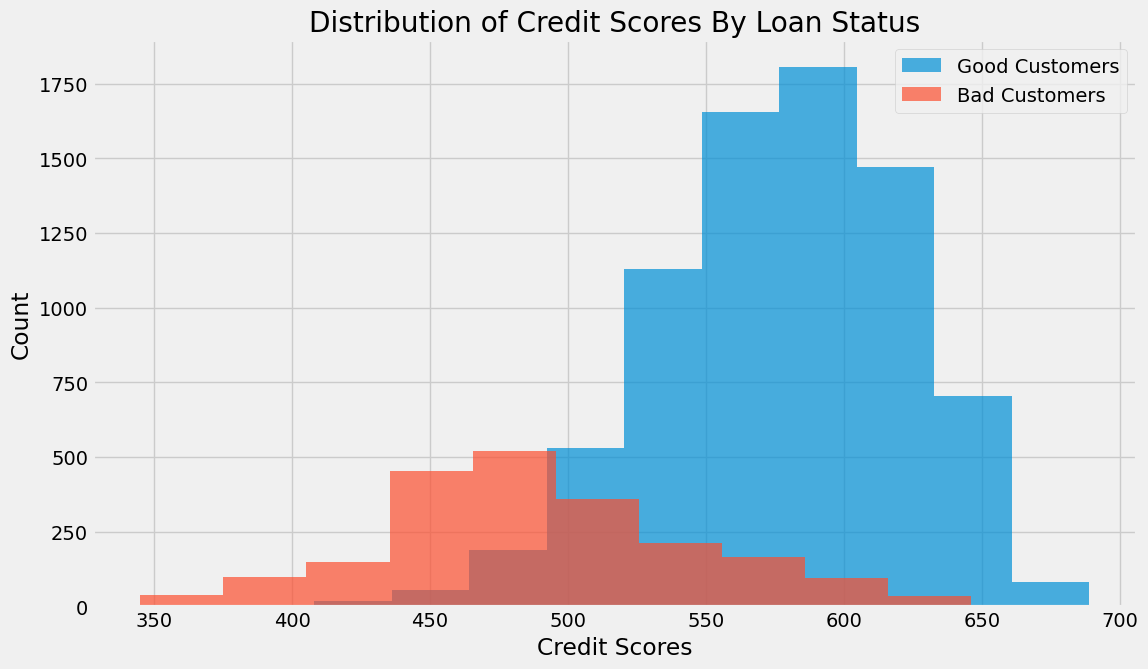

In [ ]:
plt.figure(figsize=FIGSIZE)
credit_scores_df.loc[credit_scores_df["loan_status"]==0, "credit_score"].hist(alpha=0.7, label="Good Customers")
credit_scores_df.loc[credit_scores_df["loan_status"]==1, "credit_score"].hist(alpha=0.7, label="Bad Customers")
plt.title("Distribution of Credit Scores By Loan Status")
plt.xlabel("Credit Scores")
plt.ylabel("Count")
plt.legend()
plt.savefig("../reports/figures/distribution_of_credit_scores_by_loan_status.png")
plt.show()

This shows that customers has a high chance of default if their credit scores are low.

In [ ]:
# Create report to management
# Prepare columns that will be used for reporting
report_df = credit_scores_df[["credit_score", "credit_level", "credit_lower_bound", "credit_upper_bound", "credit_description", "loan_status"]]

# Count every Good Users and Bad Users in each FICO credit levels
report_agg_df = report_df\
    .groupby(["credit_level", "credit_lower_bound", "credit_upper_bound", "credit_description"])["loan_status"]\
    .value_counts()\
    .unstack()\
    .reset_index()\
    .rename(columns={
        0: "Good Customers",
        1: "Bad Customers",
        "credit_level": "Credit Level",
        "credit_lower_bound": "Credit Lower Bound", 
        "credit_upper_bound": "Credit Upper Bound", 
        "credit_description": "Credit Description"
    })\
    .fillna(0)


report_agg_df = report_agg_df.rename_axis(None, axis=1)
report_agg_df["Customers"] = report_agg_df["Good Customers"] + report_agg_df["Bad Customers"]

# Proportion of customers exists in each credit levels
report_agg_df["Customers Rate"] = report_agg_df["Customers"] / report_agg_df["Customers"].sum() * 100
# Proportion of `Bad Customers`` in each credit levels

report_agg_df["Default Rate"] = report_agg_df["Bad Customers"] / report_agg_df["Customers"] * 100
report_agg_df["Reverse Cumulative Customers"] = report_agg_df["Customers"][::-1].cumsum()
report_agg_df["Reverse Cumulative Good Customers"] = report_agg_df["Good Customers"][::-1].cumsum()
report_agg_df["Reverse Cumulative Bad Customers"] = report_agg_df["Bad Customers"][::-1].cumsum()

# Calculate the cumulative percentage of `Good Customers` covered from all customers (start at level 8 down to level 1)
report_agg_df["Good Customers Coverage"] = report_agg_df["Reverse Cumulative Good Customers"] / report_agg_df["Good Customers"].sum()
# Calculate the cumulative percentage of `Bad Customers` covered from all customers (start at level 8 down to level 1)
report_agg_df["Loss Coverage"] = report_agg_df["Reverse Cumulative Bad Customers"] / report_agg_df["Reverse Cumulative Customers"]

In [ ]:
report_agg_df[[
    "Credit Level", "Credit Lower Bound", 
    "Credit Upper Bound", "Credit Description",
    "Customers", "Customers Rate", 
    "Good Customers", "Bad Customers", 
    "Default Rate", "Good Customers Coverage", 
    "Loss Coverage"
]]

,Credit Level,Credit Lower Bound,Credit Upper Bound,Credit Description,Customers,Customers Rate,Good Customers,Bad Customers,Default Rate,Good Customers Coverage,Loss Coverage
0,1,-inf,350.0,Very Poor,5.0,0.051151,0.0,5.0,100.000000,1.000000,0.218210
1,2,350.0,400.0,Poor,117.0,1.196931,0.0,117.0,100.000000,1.000000,0.217810
2,3,400.0,450.0,Below Average,411.0,4.204604,43.0,368.0,89.537713,1.000000,0.208329
3,4,450.0,500.0,Average,1158.0,11.846547,330.0,828.0,71.502591,0.994373,0.177775
4,5,500.0,550.0,Above Average,2131.0,21.800512,1643.0,488.0,22.900047,0.951191,0.100816
5,6,550.0,600.0,Good,3352.0,34.291560,3093.0,259.0,7.726730,0.736195,0.054930
6,7,600.0,650.0,Very Good,2382.0,24.368286,2314.0,68.0,2.854744,0.331458,0.026144
7,8,650.0,700.0,Excellent,219.0,2.240409,219.0,0.0,0.000000,0.028657,0.000000


In [ ]:
report_agg_df[[
    "Credit Level", "Credit Lower Bound", 
    "Credit Upper Bound", "Credit Description",
    "Customers", "Customers Rate", 
    "Good Customers", "Bad Customers", 
    "Default Rate", "Good Customers Coverage", 
    "Loss Coverage"
]].to_csv("../reports/coverage_table.csv", index=False)

## Explanation
This report table is a summary of credit level statistics based on the count of Good Customer and Bad Customers inside each credit level.

1. **Credit Level**: This column indicates the different levels of creditworthiness.
2. **Credit Lower** Bound and Credit Upper Bound: These columns define the score ranges for each credit level. For example, the "Very Poor" credit level ranges from negative infinity (or the lowest possible score) up to 350.
3. **Credit Description**: This column provides a description or label for each credit level.
4. **Customers**: The number of customers or individuals falling within each credit level.
5. **Customers Rate**: This column might represent the percentage of customers in each credit level relative to the total number of customers.
6. **Good Customers and Bad Customers**: The number of customers within each credit level who are classified as "Good" (low credit risk) or "Bad" (high credit risk).
7. **Default Rate**: This column indicates the percentage of customers within each credit level who have defaulted on their obligations.
8. **Good Customers Coverage**: Cumulative percentage of "Good" customers covered within each credit level start from the highest credit level.
9. **Loss Coverage**: cumulative percentage of exposed losses that we are willing to accept for a given loan, starting from a certain credit level until the highes credit level.